In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [152]:
df = pd.read_csv(r"D:\Data Analyst Studies\Projects\Python\Arima\Weekly Sales Data.csv")

In [153]:
df.head()

,Week Start Date,Sum of sales
0,05-01-2015,14316.0
1,12-01-2015,14055.0
2,19-01-2015,14118.0
3,26-01-2015,14420.0
4,02-02-2015,15664.0


In [154]:
df.columns= ["Week", "Sales"]
df.head()

,Week,Sales
0,05-01-2015,14316.0
1,12-01-2015,14055.0
2,19-01-2015,14118.0
3,26-01-2015,14420.0
4,02-02-2015,15664.0


In [155]:
df.info

<bound method DataFrame.info of            Week    Sales
0    05-01-2015  14316.0
1    12-01-2015  14055.0
2    19-01-2015  14118.0
3    26-01-2015  14420.0
4    02-02-2015  15664.0
..          ...      ...
151         NaN      NaN
152         NaN      NaN
153         NaN      NaN
154         NaN      NaN
155         NaN      NaN

[156 rows x 2 columns]>

In [156]:
df = df.drop(index=range(104, 156))

In [157]:
df.info

<bound method DataFrame.info of            Week    Sales
0    05-01-2015  14316.0
1    12-01-2015  14055.0
2    19-01-2015  14118.0
3    26-01-2015  14420.0
4    02-02-2015  15664.0
..          ...      ...
99   28-11-2016  19504.0
100  05-12-2016  16938.0
101  12-12-2016  16874.0
102  19-12-2016  17124.0
103  26-12-2016  16771.0

[104 rows x 2 columns]>

In [158]:
df.tail()

,Week,Sales
99,28-11-2016,19504.0
100,05-12-2016,16938.0
101,12-12-2016,16874.0
102,19-12-2016,17124.0
103,26-12-2016,16771.0


In [159]:
df['Week'] = pd.to_datetime(df['Week'], format="%d-%m-%Y")

In [160]:
df.head()

,Week,Sales
0,2015-01-05,14316.0
1,2015-01-12,14055.0
2,2015-01-19,14118.0
3,2015-01-26,14420.0
4,2015-02-02,15664.0


In [161]:
df.set_index('Week', inplace=True)

In [162]:
df.describe()

,Sales
count,104.000000
mean,21738.307692
std,4027.812167
min,14055.000000
25%,18812.500000
50%,22089.500000
75%,24728.250000
max,29185.000000


<Axes: xlabel='Week'>

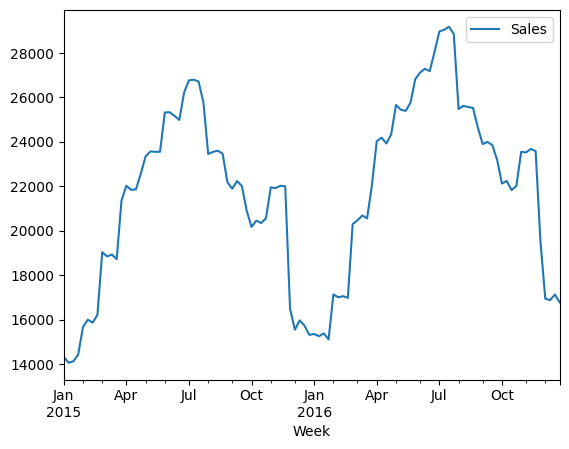

In [163]:
df.plot()

In [164]:
!pip install statsmodels

In [165]:
from statsmodels.tsa.stattools import adfuller

In [166]:
test_result=adfuller(df['Sales'])

In [167]:
def adfuller_test(Sales):
    result = adfuller(Sales)
    labels = ['ADF test statistics', 'p-value', '#lag used', 'number of observations used']
    for value, label in zip(result,labels):
        print(label+' : ' +str(value))
    if result[1] <= 0.05:\
        print("Strong evidence against the null hypothesis(H0), reject null hypothesis")
    else:
        print('weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary')

In [168]:
adfuller_test(df['Sales'])

ADF test statistics : -2.165894037556428
p-value : 0.2188559249273042
#lag used : 1
number of observations used : 102
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


In [169]:
df['Seasonal First Difference'] = df['Sales']- df['Sales'].shift(7)

In [170]:
df.head(15)

,Sales,Seasonal First Difference
Week,,
2015-01-05,14316.0,NaN
2015-01-12,14055.0,NaN
2015-01-19,14118.0,NaN
2015-01-26,14420.0,NaN
2015-02-02,15664.0,NaN
2015-02-09,15993.0,NaN
2015-02-16,15860.0,NaN
2015-02-23,16213.0,1897.0
2015-03-02,19030.0,4975.0


In [172]:
adfuller_test(df['Seasonal First Difference'].dropna())

ADF test statistics : -1.7907198927716168
p-value : 0.3850786453541027
#lag used : 8
number of observations used : 88
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


In [173]:
##Since Seasonal differencing suggesting the series is till non-stationary, I will use double differencing.

df['Regular First Difference']= df['Sales']-df['Sales'].shift(1)

In [174]:
df['Double Differenced'] = df['Regular First Difference']- df['Regular First Difference'].shift(7)

In [175]:
adfuller_test(df['Double Differenced'].dropna())

ADF test statistics : -3.5901802676280807
p-value : 0.005951558937703449
#lag used : 7
number of observations used : 88
Strong evidence against the null hypothesis(H0), reject null hypothesis


<Axes: xlabel='Week'>

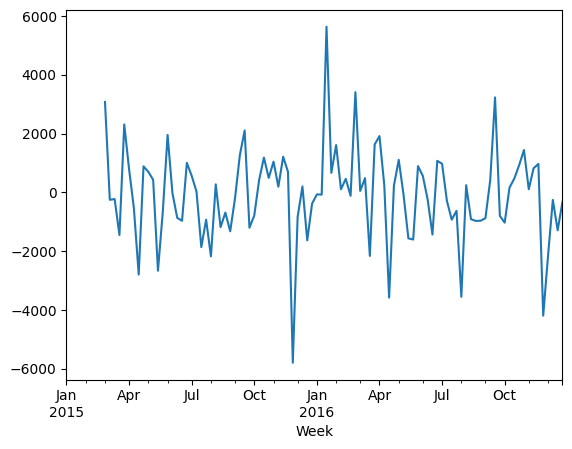

In [176]:
df['Double Differenced'].plot()

In [177]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

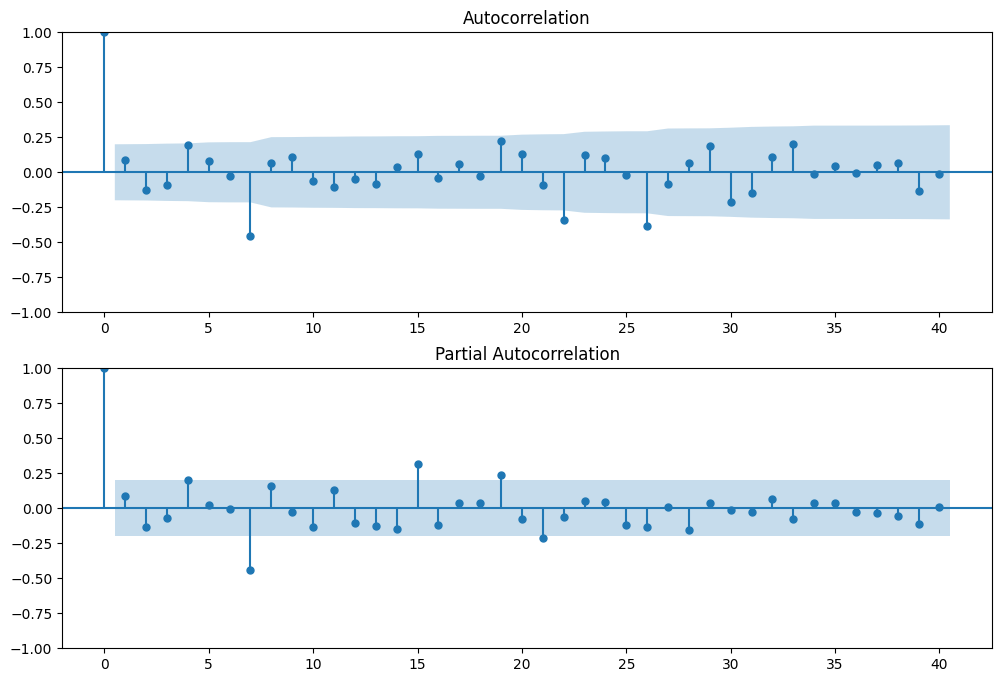

In [178]:
## Autocorrelation and Partial Autocorrelation
fig = plt.figure(figsize=(12,8))

## ACF Plot
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Double Differenced'].dropna(), lags=40, ax=ax1)

## PACF Plot
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Double Differenced'].dropna(), lags=40, ax=ax2)

In [180]:
model=sm.tsa.statespace.SARIMAX(df['Sales'], order=(1,2,1),seasonal_order=(1,2,1,7))
results=model.fit()

<Axes: xlabel='Week'>

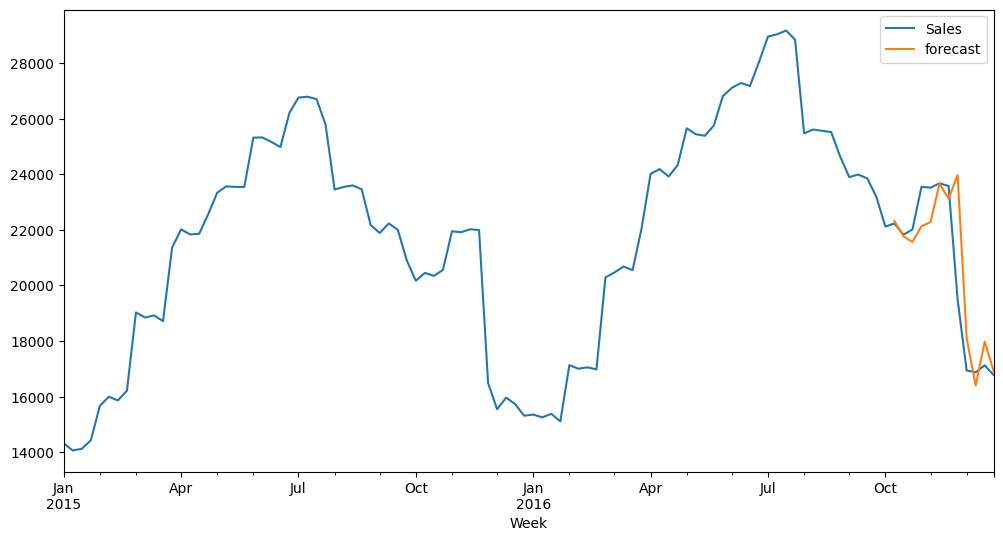

In [181]:
df['forecast']=results.predict(start = 92, end = 103, dynamic = False)
df[['Sales', 'forecast']].plot(figsize=(12,6))


In [182]:
from pandas.tseries.offsets import DateOffset
future_dates = pd.date_range(start=df.index[-1], periods = 26, freq='W')[1:]

In [183]:
future_dataset_df=pd.DataFrame(index=future_dates[1:], columns=df.columns)

In [184]:
future_df=pd.concat([df, future_dataset_df])

In [185]:
# Generate predictions
future_preds = results.predict(start=104, end=127)

# Assign forecast to future_df using integer position
future_df.loc[future_df.index[104:128], 'forecast'] = future_preds.values

<Axes: >

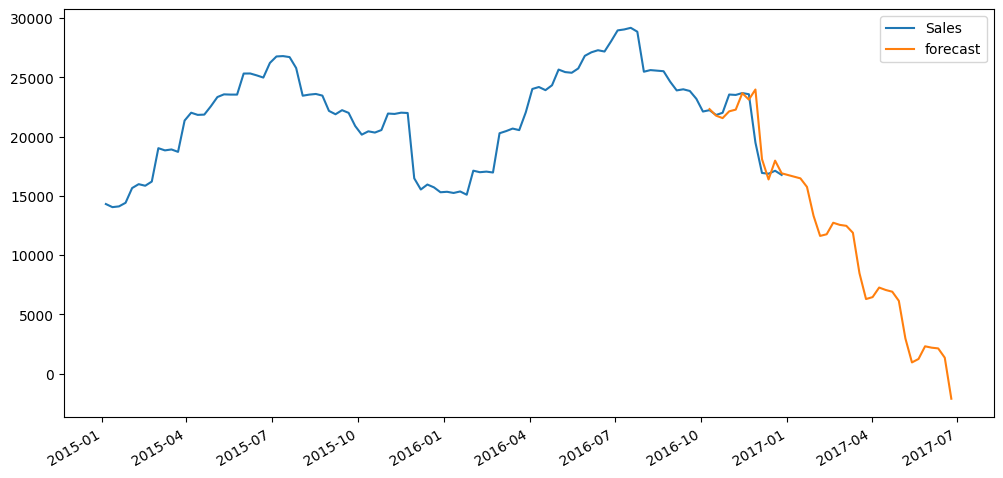

In [187]:
future_df[['Sales', 'forecast']].plot(figsize=(12, 6))

In [188]:
# Filter rows with no NaNs
mask = future_df['Sales'].notna() & future_df['forecast'].notna()
forecast_actuals = future_df.loc[mask, 'Sales']
forecast_preds = future_df.loc[mask, 'forecast']

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(forecast_actuals, forecast_preds)
rmse = np.sqrt(mean_squared_error(forecast_actuals, forecast_preds))

print(f"Forecast MAE: {mae:.2f}")
print(f"Forecast RMSE: {rmse:.2f}")

Forecast MAE: 902.91
Forecast RMSE: 1481.70


In [189]:
mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 8.97%
